# ***TASK 1***

Description:

"This task is aiming to provide a binary classification of the column 'Type'. The dataset is provided into two different tables with unique identifier of column 'ID'. Tip: This column (ID) can be used to match the two tables."

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import GradientBoostingClassifier

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

## Read data

In [2]:
df2 = pd.read_csv('./data/Task1_2.csv', sep=';')
print(df2.shape)

(4070, 9)


In [3]:
df2.head()

,POUG,TRE,ID,ZUB,VOL,UIO,VBNM,Type,OIN
0,1,1.750,0,t,f,uuuu,t,n,17.92
1,0,0.290,1,f,f,wwww,f,n,16.92
2,1,0.000,2,f,f,wwww,t,n,31.25
3,0,0.335,3,f,f,uuuu,f,n,48.17
4,0,0.500,4,t,f,wwww,f,n,32.33


In [4]:
df1 = pd.read_csv('./data/Task1_1.csv', sep=';')
print(df1.shape)

(4070, 11)


In [5]:
df1.head()

,ID,UKL,GJAH,ZIK,HUI,ERZ,CDx,BJZHD,NKJUD,LPI,BJKG
0,0,160,oooo,x,oooo,www,5.0,vvvv,80.0,800000.0,qqqq
1,1,153,rrr,NaN,uuu,pppp,0.0,mmm,200.0,2000000.0,qqqq
2,2,5,oooo,x,oooo,www,19.0,hh,96.0,960000.0,hh
3,3,9,oooo,NaN,oooo,www,120.0,kkk,0.0,0.0,qqq
4,4,40,oooo,y,oooo,www,0.0,mmm,232.0,2320000.0,qqqq


## Preprocess & EDA

### Drop duplicates

Prior to merging `df1` and `df2` we need to ensure unique records. We see below there are 370 duplicate rows, where "duplicate" is defined as having the same value for all columns in a row.

In [6]:
print(f"Number of duplicates in df1: {df1.duplicated().sum()}")
print(f"Number of duplicates in df2: {df2.duplicated().sum()}")

Number of duplicates in df1: 370
Number of duplicates in df2: 370


In [7]:
df1 = df1.drop_duplicates().reset_index(drop=True)
df2 = df2.drop_duplicates().reset_index(drop=True)

assert df1.duplicated().sum() == 0  # sanity check
assert df2.duplicated().sum() == 0

print(df1.shape)
print(df2.shape)

(3700, 11)
(3700, 9)


### Merge

Although it's not explicitly stated in the instructions, I assume an inner join is desired. As we can see, there's a 100% match rate.

In [8]:
df = df1.merge(df2, on='ID', how='inner')
print(df.shape)

(3700, 19)


In [9]:
df.head()

,ID,UKL,GJAH,ZIK,HUI,ERZ,CDx,BJZHD,NKJUD,LPI,BJKG,POUG,TRE,ZUB,VOL,UIO,VBNM,Type,OIN
0,0,160,oooo,x,oooo,www,5.0,vvvv,80.0,800000.0,qqqq,1,1.750,t,f,uuuu,t,n,17.92
1,1,153,rrr,NaN,uuu,pppp,0.0,mmm,200.0,2000000.0,qqqq,0,0.290,f,f,wwww,f,n,16.92
2,2,5,oooo,x,oooo,www,19.0,hh,96.0,960000.0,hh,1,0.000,f,f,wwww,t,n,31.25
3,3,9,oooo,NaN,oooo,www,120.0,kkk,0.0,0.0,qqq,0,0.335,f,f,uuuu,f,n,48.17
4,4,40,oooo,y,oooo,www,0.0,mmm,232.0,2320000.0,qqqq,0,0.500,t,f,wwww,f,n,32.33


In [10]:
# Drop ID column since no longer needed for modeling
del df['ID']

### Class imbalance

As the instructions suggested and the data below confirms, this is a binary classification problem. Importantly, the target variable is highly class imbalanced (i.e. the distribution of classes is highly unequal), with ~92.5% of cases being "y", while only ~7.5% being "n". While phenomenon is common in real-world applications, it poses some modeling challenges.

To address this, **I focus on performance metrics that differentiate between performance by class (e.g. precision, recall, F1 score, balanced accuracy), rather than "global" performance indicators like accuracy. The reason being that in expectation, a model could be (in this case) about 92.5% accurate simply by predicting the dominant class for every observation, which would be a poor model.**

In [11]:
df['Type'].value_counts(normalize=True)

y    0.925405
n    0.074595
Name: Type, dtype: float64

### Missing data

As we see below, several of our predictor features contain missing data (though not our target feature). Because I use an ensemble method below that averages predictions across three different ML models, two of which cannot easily handle missing data (SVM & gradient boosted trees) I impute these missing values.

Several imputation strategies exist for missing data, including:
- listwise deletion - drop rows with any missing column values
- unconditional imputation - use measure of central tendency (mean or median) among non-missing rows
- conditional imputation - use e.g. a ML model to first impute the data iteratively by feature, using all other features

While conditional imputation offers the best performance in expectation, for sake of time I use an unconditional imputation method.

**For our modeling purposes, imputation is importantly only required for numeric features**, not categorical features. This is because we'll one-hot encode categorical features, which enables us to code "missing" as simply another feature value. 

In [12]:
# Share of missing data by column
df.isnull().mean()

UKL      0.000000
GJAH     0.017297
ZIK      0.579730
HUI      0.000000
ERZ      0.017297
CDx      0.000000
BJZHD    0.017838
NKJUD    0.027027
LPI      0.027027
BJKG     0.017838
POUG     0.000000
TRE      0.000000
ZUB      0.000000
VOL      0.000000
UIO      0.010541
VBNM     0.000000
Type     0.000000
OIN      0.010541
dtype: float64

In [13]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols.remove('POUG')  # this appears categorical so we remove

In [14]:
# Statistical moments before imputation
df[numeric_cols].describe()

,UKL,CDx,NKJUD,LPI,TRE,OIN
count,3700.000000,3700.000000,3600.000000,3.600000e+03,3700.000000,3661.000000
mean,95.688378,2246.705946,162.695000,1.626950e+06,3.439496,32.820713
std,56.382436,8708.571126,156.045682,1.560457e+06,4.335229,12.666181
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000,13.750000
25%,46.000000,0.000000,0.000000,0.000000e+00,0.500000,23.000000
50%,99.000000,113.000000,120.000000,1.200000e+06,1.750000,28.670000
75%,152.000000,1059.750000,280.000000,2.800000e+06,5.000000,40.830000
max,179.000000,100000.000000,1160.000000,1.160000e+07,28.500000,80.250000


In [15]:
for col in numeric_cols:
    mu = df[df[col].notnull()][col].mean()  # mean as measure of central tendency
    df[col] = np.where(df[col].isnull(), mu, df[col])

In [16]:
assert df[numeric_cols].isnull().mean().sum() == 0

In [17]:
# Verify statistical moments appear similar after imputation
df[numeric_cols].describe()

,UKL,CDx,NKJUD,LPI,TRE,OIN
count,3700.000000,3700.000000,3700.000000,3.700000e+03,3700.000000,3700.000000
mean,95.688378,2246.705946,162.695000,1.626950e+06,3.439496,32.820713
std,56.382436,8708.571126,153.921934,1.539219e+06,4.335229,12.599232
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000,13.750000
25%,46.000000,0.000000,0.000000,0.000000e+00,0.500000,23.000000
50%,99.000000,113.000000,120.000000,1.200000e+06,1.750000,28.670000
75%,152.000000,1059.750000,274.000000,2.740000e+06,5.000000,40.000000
max,179.000000,100000.000000,1160.000000,1.160000e+07,28.500000,80.250000


### One-hot encode categorical features

One hot encoding a feature involves creating a new boolean feature to typically represent each unique value in source feature. To do this we use sklearn's `OneHotEncoder` class. Depending on the model (e.g. linear regression or regression using maximum likelihood without regularization), it's necessary to drop one category value, otherwise the one-hot columns will be perfectly collinear. However, collinearity is typically not a problem for machine learning models.

In [18]:
categorical_cols = [i for i in df.columns if i not in numeric_cols and "Type" not in i]  # exclude target

In [19]:
# Number of unique values among categorical features
df[categorical_cols].nunique(dropna=False)

GJAH      4
ZIK       3
HUI       3
ERZ       4
BJZHD    13
BJKG      9
POUG     23
ZUB       2
VOL       2
UIO       3
VBNM      2
dtype: int64

In [20]:
X = OneHotEncoder().fit_transform(df[categorical_cols]).toarray()
assert (df[categorical_cols].nunique(dropna=False).sum() == X.shape[1])  # ensure yields full number of unique values

#### Concatenate numeric features 

To complete our `X` matrix of predictor features, we concatenate the numeric features to our newly created array of one-hot features

In [21]:
X = np.concatenate((X, df[numeric_cols].values), axis=1)

### Label encode target feature

Label encoding is the process of converting the non-numeric values of a categorical feature to a numeric representation. 

**Given the class imbalance described above, I recode the rarer "n" category to 1, and the more common "y" category to 0.** This coding procedure is common when modeling with imbalanced data, allow us to focus on classical measures of precision and recall, which assume the user is interested in the harder-to-predict class labeled 1.

In [22]:
y = df['Type'].replace({'n': 1, 'y': 0}).values

### Train-test split

I split the data into train and test/holdout subsets, allowing me to evaluate the trained model performance on the unseen test set. Although this split is admittedly somewhat arbitrary since we have no "true" test set in this case, it nonetheless provides a straightforward way to evaluate model performance and compare across models on unseen data. 

**Note - An alternative would have been to use the full dataset, combined with [k-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). However, since I am already using cross-validation to search for optimal model hyperparameters (see below), this would've added additional complexity to this short assigment, so I stuck with simpler train/test split.**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

print(X_train.shape)
print(X_test.shape)

(3330, 74)
(370, 74)


### Data normalization

We use sklearn's `MinMaxScaler`, which transforms each of our predictor features to 0-1 scale. Data normalization is used to convert the range of features to a similar scale, which speeds up training. An alternative method would be standardization (i.e. z-score normalization; mean of 0, std of 1).

**Importantly normalization takes place *after* splitting the data into train and test sets**. This ensures not only that there is no data leakage between subsets, but also that the transformed distributions are consistent between subsets (e.g. all range from 0-1, since they're using the minimum and maximum values of that subset). 

In [24]:
scaler = MinMaxScaler()
X_train_ = scaler.fit_transform(X_train)
X_test_ = scaler.fit_transform(X_test)

## Modeling

I use an ensemble of three distinct types of classification models, ensembling predictions using hard voting. [Ensembling](https://en.wikipedia.org/wiki/Ensemble_learning) is a meta approach to machine learning that seeks better predictive performance by combining predictions from different models. Hard voting is the process in which the final prediction for an individual observation is decided by the majority of votes among the models. In this case, I prefer hard voting to soft voting (i.e. combining predicted *probabilities* that underlie the decision function) as one of my ensembler models, naive Bayes, is a notoriously poor estimator. 

The three models I use are:
- Support vector machines
- Naive Bayes
- Gradient boosted decision trees


Prior to ensembling predictions, I optimize each model's performance using a [grid search](https://en.wikipedia.org/wiki/Hyperparameter_optimization) algorithm. Sklearn's grid search algorithm compares model performance for each hyperparameter combination across five cross-validation subsets (by default), selecting the best combination of hyperparameters. I optimize using the [f1 score](https://en.wikipedia.org/wiki/F-score). Auxilliary results showed performance metrics from all hyperoptimized models outperformed the default hyperarameters of each model.

### Performance metrics

The choice of which particular performance metric(s) to focus on depends in large part on the requirements of the modelling task. Without knowing more about the target feature, `Type`, or the severity of various prediction errors ([type I vs. type 2](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors)), I choose to focus on the `f1 score`, which is interpreted as the harmonic mean of prediction and recall, ranging between 0-1, with 1 being best. 

In [25]:
def metrics(y_true, y_pred):
    '''
    Calculates binary classification performance metrics for a given model.
    :param y_true: array_like, truth values as int
    :param y_pred: array_like, predicted values as int
    :returns: dict, with keys for each metric: 
        accuracy - proportion of correct predictions out of total predictions
        balanced accuracy - average of recall obtained on each class
        sensitivity - (aka recall) of all true positives, how many did we correctly predict as positive
        specificity - (aka selectivity/TNR), of all true negatives, how many did we correctly predict as negative
        precision - of all predicted positive cases, how many were actually positive
        F1 score - harmonic/weighted mean of precision and sensitivity scores
        ROC-AUC - area under receiver operating characteristic curve
        
    '''
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    metrics_dict = {}
    rounding = 6
    metrics_dict['accuracy'] = round((tp + tn) / len(y_true), rounding)
    metrics_dict['bal_accuracy'] = round(balanced_accuracy_score(y_true, y_pred), rounding)
    metrics_dict['sensitivity'] = round(tp / (fn + tp), rounding) # aka recall
    metrics_dict['specificity'] = round(tn / (tn + fp), rounding) # aka TNR
    metrics_dict['precision'] = round(tp / (tp + fp), rounding)
    metrics_dict['f1'] = round(2 * (metrics_dict['precision'] * metrics_dict['sensitivity']) \
                        / (metrics_dict['precision'] + metrics_dict['sensitivity']), rounding)
    metrics_dict['roc_auc'] = round(roc_auc_score(y_true, y_pred), rounding)
    
    return metrics_dict


In [26]:
# Initialize empty dict for performance across models
model_performance = {}

### Model 1: Support vector machines (SVM) 

[SVM](https://en.wikipedia.org/wiki/Support_vector_machine) is a type of supervised ML algorithm use for classification and regression. In support vector classification, the model finds a hyperplane in n-dimensional space that maximizes the distance (margin) between classes. 

I optimize the model hyperaparameters `C` and `kernel`. Whereas the former controls the regularization parameter (squared l2 penalty) that in turn affects the margin between classes, the latter specifies the kernel type to be used by the algorithm.

In [27]:
params = {"C": [0.1, 1.0, 10, 100],
          "kernel": ['rbf', 'poly']}  # Hyperparameters to grid search

svc = GridSearchCV(estimator = SVC(probability=True), 
                    param_grid = params,
                    scoring='f1', 
                    n_jobs=-1, 
                    verbose=1)

svc.fit(X_train_, y_train)

print(f"\nBest model hyperparameters: '{svc.best_params_}'")

pred_svc = svc.predict(X_test_)
prob_svc = svc.predict_proba(X_test_)

print("\nPerformance metrics:")
model_performance['svc'] = metrics(y_test, pred_svc)
model_performance['svc']

Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best model hyperparameters: '{'C': 10, 'kernel': 'rbf'}'

Performance metrics:


{'accuracy': 0.997297,
 'bal_accuracy': 0.978261,
 'sensitivity': 0.956522,
 'specificity': 1.0,
 'precision': 1.0,
 'f1': 0.977778,
 'roc_auc': 0.978261}

### Model 2: Naive Bayes, CategoricalNB

Naive Bayes is a family of simple, supervised learning algorithms based on Bayes' theorem combined with a strong "naive" assumption of conditional independence between features given the value of the outcome variable. Although this assumption is frequently violated in many real-world applications, naive Bayes algorithms often work well as classifiers (e.g. especially in document classification and spam filtering). An explanation for this paradox can be found [here](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf); essentially, the answer lies in the distribution of dependence within a class often cancelling each other out. Importantly, naive Bayes models are poor estimators, meaning the probability outputs should not be relied upon. 

Comparing various naive Bayes implementations (GaussianNB, MultinomialNB, ComplementNB, and CategoricalNB), model performance was markedly better with Categorical Naive Bayes, according to auxilliary analyses. 

For this model, I optimize two hyperparameters, `alpha`, and `min_categories`, which are the additive (Laplace) smoother, and the minimum number of categories per features, respectively. Auxilliary analyses showed that this flavor of naive Bayes struggled when it encountered unseen values in the test set, which this hyperparameters resolves.

In [28]:
params = {"alpha": [0.001, 0.01, 0.1, 1.0, 10],
          "min_categories": [2, 5, 10, 20, 50, 100, 500]}

nb = GridSearchCV(estimator = CategoricalNB(force_alpha=True), 
                    param_grid = params,
                    scoring='f1', 
                    n_jobs=-1, 
                    verbose=1)

nb.fit(X_train_, y_train)

print(f"\nBest model hyperparameters: '{nb.best_params_}'")

pred_nb = nb.predict(X_test_)

print("\nPerformance metrics:")
model_performance['nb'] = metrics(y_test, pred_nb)
model_performance['nb']

Fitting 5 folds for each of 35 candidates, totalling 175 fits

Best model hyperparameters: '{'alpha': 0.01, 'min_categories': 500}'

Performance metrics:


{'accuracy': 0.894595,
 'bal_accuracy': 0.801717,
 'sensitivity': 0.695652,
 'specificity': 0.907781,
 'precision': 0.333333,
 'f1': 0.450704,
 'roc_auc': 0.801717}

### Model 3: Boosted decision tree classifier

Gradient boosting is a ML technique for both classification and regression tasks in which an ensemble of weak prediction models, typically decision trees, are successively fit on the pseudo-residuals from the previous step.

As compared to the other two models, boosted decision trees have a considerable number of hyperparameters to potentially optimize. I choose to focus on a key set of hyperparameters that tend to have the largest influence on performance:
- learning rate
- number of total boosted decision trees to fit
- max depth of each decision tree

In [29]:
params = {"learning_rate": [0.05, 0.1, 0.2, 0.4, 0.6],
          "n_estimators": [50, 100, 120, 300],
          "max_depth": [3, 5, 7, 9, 11]}

gbc = GridSearchCV(estimator = GradientBoostingClassifier(random_state=1), 
                    param_grid = params,
                    scoring='f1', 
                    n_jobs=-1, 
                    verbose=1)

gbc.fit(X_train_, y_train)

print(f"\nBest model hyperparameters: '{gbc.best_params_}'")

pred_gbc = gbc.predict(X_test_)

print("\nPerformance metrics:")
model_performance['gbc'] = metrics(y_test, pred_gbc)
model_performance['gbc']

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Best model hyperparameters: '{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}'

Performance metrics:


{'accuracy': 0.972973,
 'bal_accuracy': 0.965293,
 'sensitivity': 0.956522,
 'specificity': 0.974063,
 'precision': 0.709677,
 'f1': 0.814815,
 'roc_auc': 0.965293}

### Ensembling predictions using hard voting

I combine models using a simple majority voting method (i.e. the mode). 

In [30]:
ensemble = pd.DataFrame([pred_svc, pred_nb,  pred_gbc]).T

In [31]:
ensemble = ensemble.apply(lambda x: x.value_counts().index[0], axis=1)

In [32]:
model_performance['ens'] = metrics(y_test, ensemble)
model_performance['ens']

{'accuracy': 0.991892,
 'bal_accuracy': 0.975379,
 'sensitivity': 0.956522,
 'specificity': 0.994236,
 'precision': 0.916667,
 'f1': 0.936171,
 'roc_auc': 0.975379}

## Comparing classification performance across models

Comparing performance of the individual models, the support vector classifier performs best, even outdoing our ensembler method. Normally, ensembling produces better performance than a single model; however, in our case the performance of the SVC model far surpassed all other models.

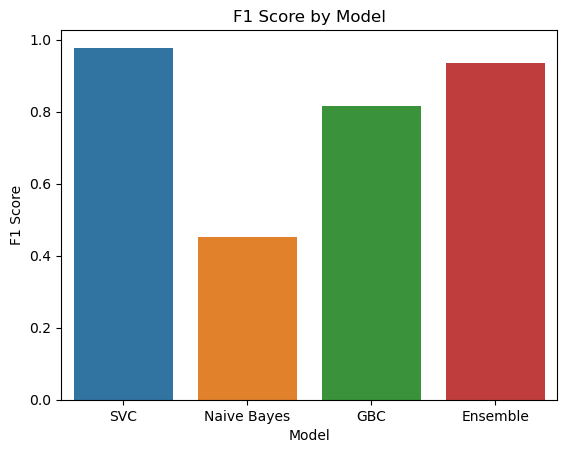

In [33]:
labels = ['SVC', 'Naive Bayes', 'GBC', 'Ensemble']
metrics_ = [model_performance[i]['f1'] for i in ['svc', 'nb', 'gbc', 'ens']]
sns.barplot(x=labels, y=metrics_)
plt.xlabel("Model")
plt.ylabel("F1 Score")
plt.title("F1 Score by Model")
plt.show()